C:\Users\user\Documents\10acadamy\week_two\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


         avg_tcp_retransmission     avg_rtt  avg_throughput
cluster                                                    
0                  4.512270e+06   40.963723     5893.559238
1                  1.979019e+06  202.042974    33450.770466
2                  2.216722e+09   71.934100     6089.847350


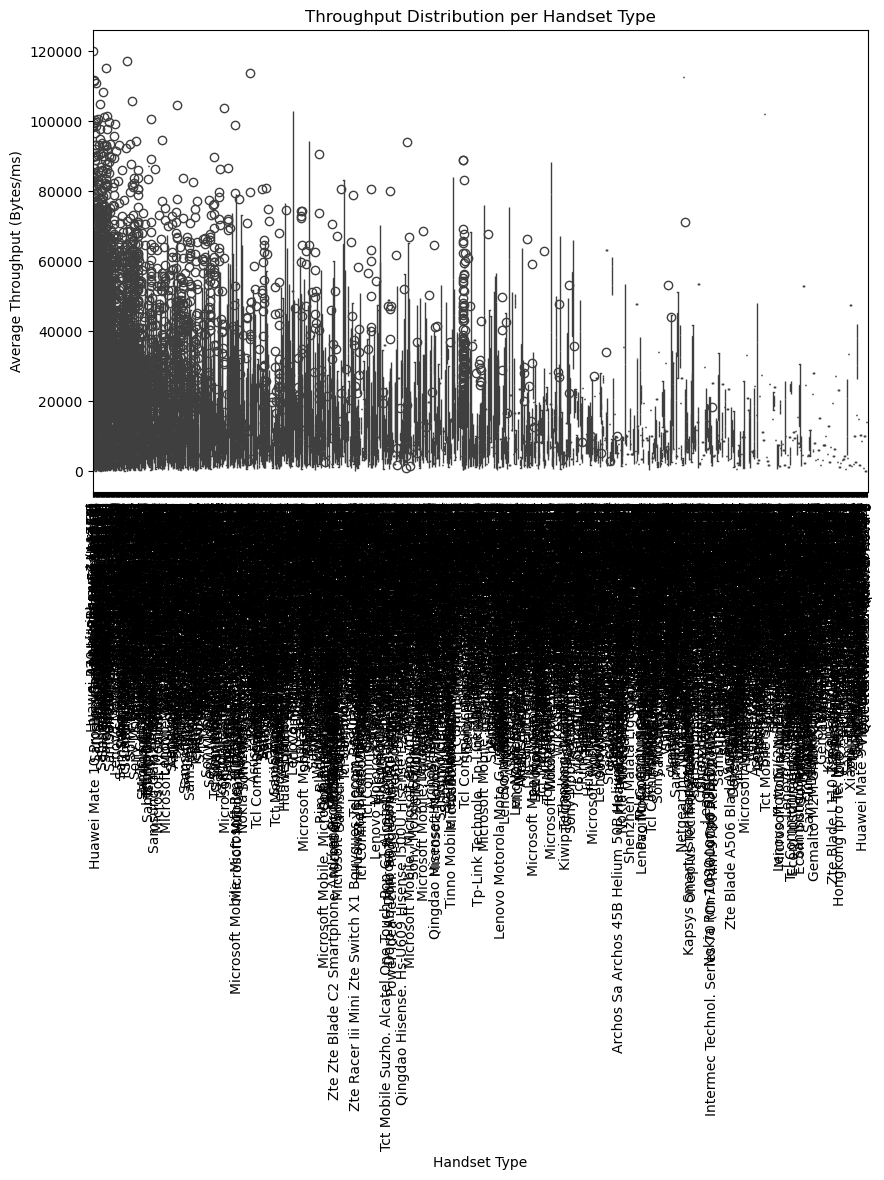

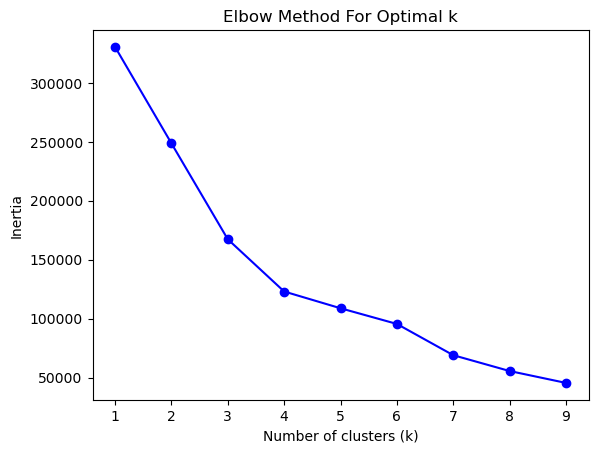

Silhouette Score: 0.776394539603041


In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Add the 'scripts' folder to the Python path for loading data
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))
from load_data import load_data_from_postgres

# Step 1: Load Experience Data
def load_experience_data():
    query = '''
    SELECT "MSISDN/Number" as customer_id,
           AVG("TCP DL Retrans. Vol (Bytes)") as avg_tcp_retransmission,
           AVG(("Avg RTT DL (ms)" + "Avg RTT UL (ms)") / 2) as avg_rtt,  -- Taking the average of DL and UL RTT
           "Handset Type" as handset_type,
           AVG(("Total DL (Bytes)" + "Total UL (Bytes)") / "Dur. (ms)") as avg_throughput
    FROM xdr_data
    GROUP BY customer_id, handset_type;
    '''
    df = load_data_from_postgres(query)
    return df

df_experience = load_experience_data()

# Step 2: Data Preprocessing
def preprocess_data(df):
    # Fill missing values if any
    df.fillna(0, inplace=True)
    
    # Scale features for clustering
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']]),
                             columns=['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput'])
    return df_scaled, df

df_scaled, df_experience = preprocess_data(df_experience)

# Step 3: Perform K-means Clustering (k=3)
def perform_kmeans(df, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(df)
    return df, kmeans

df_clustered, kmeans = perform_kmeans(df_scaled)

# Analyze clusters: Average metrics per cluster
def analyze_clusters(df_original, df_clustered):
    df_original['cluster'] = df_clustered['cluster']
    cluster_analysis = df_original.groupby('cluster').agg({
        'avg_tcp_retransmission': 'mean',
        'avg_rtt': 'mean',
        'avg_throughput': 'mean'
    })
    return cluster_analysis

cluster_analysis = analyze_clusters(df_experience, df_clustered)
print(cluster_analysis)

# Step 4: Analyze Throughput Distribution per Handset Type
def analyze_throughput_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='handset_type', y='avg_throughput', data=df)
    plt.xticks(rotation=90)
    plt.title("Throughput Distribution per Handset Type")
    plt.ylabel("Average Throughput (Bytes/ms)")
    plt.xlabel("Handset Type")
    plt.show()

analyze_throughput_distribution(df_experience)

# Step 5: Optimize k-value using the Elbow Method
def find_optimal_k(df_scaled):
    inertia = []
    K = range(1, 10)  # Test k values from 1 to 10
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)
    
    # Plot Elbow Graph
    plt.plot(K, inertia, 'bo-')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

find_optimal_k(df_scaled)

# Optional: Evaluate K-means using silhouette score
def evaluate_kmeans(df_scaled, kmeans):
    score = silhouette_score(df_scaled, kmeans.labels_)
    print(f"Silhouette Score: {score}")

evaluate_kmeans(df_scaled, kmeans)
